This tutorial goes through the steps of taking a dual scene (that is, a scene containing synchronous measurements of tracers and inertial particles in the same volume) and exploring and analysing the data.

We start with just the inertial particles. Our example data is stored in the postptv repository, in the ``data/`` subdirectory. We open it like so:

In [1]:
from flowtracks.scene import Scene
particles = Scene('../data/particles.h5')

The ``Scene`` object allows us to iterate over the data, either trajectory by trajectory, or frame by frame. As an example of trajectory iteration, let's display a 2D view of the existing trajectories.

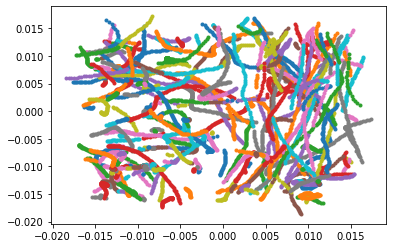

In [2]:
import matplotlib.pyplot as pl  # Plotting package
# Show results in the notebook:
%matplotlib inline

for traj in particles.iter_trajectories():
    # traj is a Trajectory object, supplied by the
    # flowtracks.trajectory module.
    pl.plot(traj.pos()[:,0], traj.pos()[:,1], '.')

pl.show()

This was easy. However, for large data sets this may be slow. I found that for most analyses it is better to iterate by frames, because we have far less frames than trajectories, and so the chunks that are being processed at each iteration are larger. Additionally, a lot of things you want to know require knowledge about the frame in which the particle is, and not just about the trajectory.

As an example, we'll find a nicely spaced frame, and show a quiver plot of particle positions and velocities.

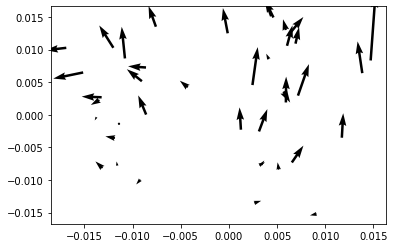

In [3]:
for frame in particles.iter_frames():
    # frame is a ParticleSnapshot object, supplied by the
    # flowtracks.trajectory module.
    if len(frame) == 40:
        pl.quiver(frame.pos()[:,0], frame.pos()[:,1],
                  frame.velocity()[:,0], frame.velocity()[:,1])
        break
pl.show()

As you can see, our observation volume is about 3x3 centimeters, and there seems to be more going on on the upper side than the lower one - in this frame. We don't know what will happen in the next - this is turbulence!

Finally, a concept we will explore in the next section, is iteration over *segments* - pairs of consecutive frames, each containing only the trajectories that are also found in the other.

## A dual scene

Now to analyse a dual scene. This is not much different. However, the scene requires, in addition to the data sources on particles and tracers, some more description: the particle properties and the common flow rate are required. So one way to create a dual scene, like the one we have in the ``data/`` directory, is to provide it straight:

In [4]:
from flowtracks.scene import DualScene
from flowtracks.particle import Particle

part = Particle(500e-6, 1450) # diameter [m], density [kg/m^3]
scene = DualScene('../data/particles.h5', '../data/tracers.h5', frate=500, particle=part)
# It is also possible to set a frame range other than all frames, see the docstring.

However, it is easier to use a configuration file containing all the data. Such a file is available in the ``data`` directory as an example:

In [5]:
cat ../data/seq_hdf.cfg

SyntaxError: invalid syntax (<ipython-input-5-eb7f8e535018>, line 1)

Note that the file refers to relative paths, so we'll first switch to the data directory. In your code, you should probably use absolute paths.

In [ ]:
%cd ../data
from flowtracks.scene import read_dual_scene
scene = read_dual_scene('../data/seq_hdf.cfg')

Now we can do calculations that relate both the tracers and the particles. Here, for example, we'll find the fluid velocity around each particle by interpolation from tracers. Like in the above example, Iteration is used to find an arbitrary frame according to some condition (here the number of particles is checked, just because it gives a nice plot). Then the fluid velocity is calculated and the quiver plot is painted so that the least tracer-like inertial particle is red, and the most tracer-like is blue. [note however that the scaling is misleading, the blue particles are not necessarily very good tracers]

In [ ]:
from numpy.linalg import norm
from flowtracks.interpolation import Interpolant
interp = Interpolant('inv', 4, 1) # Inverse Distance weighting, 1/r, 4 neighbours.

for frame, next_frame in scene.iter_segments():
    # We don't actually use ``next_frame`` here.
    if len(frame.particles) == 40:
        vel_interp = interp(frame.tracers.pos(), frame.particles.pos(),
                frame.tracers.velocity())
        rel_vel = frame.particles.velocity() - vel_interp
        
        # Color by relative slip velocity
        c = norm(rel_vel, axis=1)
        c /= max(c)
        
        pos = frame.particles.pos()
        vel = frame.particles.velocity()
        pl.quiver(pos[:,0], pos[:,1], vel[:,0], vel[:,1], c)
        break
pl.show()
    

## Analysis machinery

A loop such as the one above can be a recurring theme in our analysis code. Furthermore, we would like to read the file only once, and lump all analyses together. For this reason, the module  ``flowtrack.analysis`` exists. It provides the ``analysis()`` function, which iterates over segments, applying user-supplied analysers. An analyser is a class that describes how an analysis is to be made, and what results are to be expected from it. Here, for example, is an analyser implementing the interpolation we have seen above, for a user-defined interpolant:

In [ ]:
from flowtracks.analysis import GeneralAnalyser

class FluidVelocitiesAnalyser(GeneralAnalyser):
    def __init__(self, interp):
        """
        Arguments:
        interp - the Interpolant object to use for finding velocities.
        """
        self._interp = interp
        
    def descr(self):
        """
        Return a list of two tuples, each of the form 
        (name, data type, row length), describing the arrays returned by 
        analyse() for fluid velocity and relative velocity.
        """
        return [('fluid_vel', float, 3), ('rel_vel', float, 3)]
    
    def analyse(self, frame, next_frame):
        """
        Arguments:
        frame, next_frame - the Frame object for the currently-analysed frame
            and the one after it, respectively.
        
        Returns:
        a list of two arrays, each of shape (f,3) where f is the number of 
        particles in the current frame. 1st array - fluid velocity. 2nd array
        - relative velocity.
        """
        vel_interp = self._interp(frame.tracers.pos(), frame.particles.pos(),
            frame.tracers.velocity())
        rel_vel = frame.particles.velocity() - vel_interp
        
        return [vel_interp, rel_vel]

Note the return values of ``analyse()`` are described by ``descr()``. You can find this class too in ``flowtracks.analysis``. An example of how to use it can be found in ``scripts/analyse_fhdf.py``. We'll run the same example with our own values:

In [ ]:
from flowtracks.analysis import analysis
analysis(scene, 'results_an.h5', 'seq_hdf.cfg', [ FluidVelocitiesAnalyser(interp) ] )

This created a file called 'results_an.h5' in our working directory. It is another HDF file with the analysis results. Now we need to load this analysis in order to look at the results. After loading, any result column can be pulled out in full or partially. We can use this to plot a PDF of the relative velocity.

In [ ]:
from flowtracks.an_scene import AnalysedScene
an_res = AnalysedScene('results_an.h5')
rel_vel = norm(an_res.collect(['rel_vel'])[0], axis=1)
print rel_vel

from flowtracks.graphics import pdf_graph
pdf_graph(rel_vel, 100)

Note that we pulled out the 'rel_vel' analysis column, but we could just as easily pull out one of the trajectory columns, the AnalysedScene transparently knows where to look for the column you asked for.

And that's pretty much all there is to it. Except there is more. Check out the docstrings in the code, or ask on the openptv googlegroup for more information on what can be done.